In [ ]:
#| default_exp ce_method
import jax
jax.config.update("jax_enable_x64", True)

In [ ]:
#| export
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrn
from isssm.typing import MarkovProcessCholeskyComponents
from jax import vmap, jit
from isssm.importance_sampling import ess_pct
from isssm.pgssm import log_prob as log_prob_joint
import tensorflow_probability.substrates.jax.distributions as tfd
from jaxtyping import Float, Array, PRNGKeyArray
from typing import Tuple
from isssm.importance_sampling import normalize_weights
from isssm.util import converged
from jax.lax import while_loop, fori_loop, scan

In [ ]:
#|hide 
import jax
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
import fastcore.test as fct
from isssm.pgssm import simulate_pgssm, nb_pgssm_runnning_example
from isssm.laplace_approximation import laplace_approximation
from isssm.importance_sampling import pgssm_importance_sampling
import matplotlib.pyplot as plt

# Cross-Entropy method 
> See also the corresponding [section in my thesis](https://stefanheyder.github.io/dissertation/thesis.pdf#nameddest=subsection.3.6.2)

> [!CAUTION]
> this module is still under construction

The cross entropy method [@Rubinstein1997Optimization;@Rubinstein2004CrossEntropy] is a method for determining good importance sampling proposals. Given a parametric family of proposals $g_\theta(x)$ and target $p(x)$, the Cross-Entropy method aims at choosing $\theta$ such that the Cross Entropy 
$$
\mathcal H_{\text{CE}} \left( p \middle|\middle| g_{\theta} \right) = \int p(x) \log g_{\theta}(x) \mathrm d x
$$
is maximized. This is equivalent to minimizing the Kullback Leibler divergence between $p$ and $g_\theta$. As $H_\text{CE}$ is not analytically available, it is approximated by importance sampling itself, usually with a suitable proposal $g_{\hat\theta_0}$. Then the approximate optimization problem is solved, yielding $\hat \theta_1$. These steps are then iterated until convergence, using common random numbers to ensure convergence.

Considering the Cross-Entropy method with a Gaussian proposal $g_\theta$, we see that the optimal $\theta$ only depends on the first and second order moments of $p$, indeed the optimal Gaussian is the one that matches these moments. Unfortunately this approach is not feasible for the models we consider in this package as the dimensionality ($n \cdot m$) is likely too high to act on the joint distribution directly - matching means is feasible, but simulating from the distribution and evaluating the likelihood is infeasible. However, we can exploit the Markov structure of our models:

For the class of state space models treated in this package, it can be shown that the smoothing distribution, the target of our inference, $p(x|y)$, is again a Markov process, see Chapter 5 in [@Chopin2020Introduction], so it makes sense to approximate this distribution with a Gaussian Markov process.
For such a Gaussian Markov process it is known that the precision matrix $P$ of the joint distribution is sparse, indeed it is a block-tri-diagonal matrix.


In [ ]:
#| export
from isssm.typing import PGSSM, Observations
from isssm.util import mm_sim, mm_time_sim
import jax.scipy.linalg as jsla
from typing import NamedTuple
from isssm.util import location_antithetic, scale_antithethic
from functools import partial

class CEMProposal(NamedTuple):
    mean: Float[Array, "n+1 m"]
    R: Float[Array, "n+1 m m"]
    J_tt: Float[Array, "n m m"] # lower triangular
    J_tp1t: Float[Array, "n m m"]

def simulate_cem(proposal: CEMProposal, N: int, key: PRNGKeyArray) -> Float[Array, "N n+1 m"]:
    np1, m = proposal.mean.shape
    key, subkey = jrn.split(key)
    u = MVN(loc=jnp.zeros(m), covariance_matrix=jnp.eye(m)).sample((N, np1), subkey)
    
    # transpose to have time in first dimension
    eps = mm_time_sim(proposal.R, u).transpose((1, 0, 2))
    lower_tri_solve = partial(jsla.solve_triangular, lower=True)
    def _iteration(carry, inputs):
        x_prev, = carry
        eps, J_tt, J_tp1t = inputs

        x_next = mm_sim(J_tp1t, vmap(lower_tri_solve, (None, 0))(J_tt, x_prev)) + eps

        return (x_next,), x_next

    J_tt_ext = jnp.concatenate([jnp.eye(m)[None], proposal.J_tt], axis=0)
    J_tp1t_ext = jnp.concatenate([jnp.eye(m)[None], proposal.J_tp1t], axis=0)
    _, x = scan(
        _iteration,
        (jnp.zeros((N, m)),),
        (eps, J_tt_ext, J_tp1t_ext)
    )

    mean = proposal.mean
    samples = x.transpose((1,0,2)) + proposal.mean

    l_samples = location_antithetic(samples, mean)
    s_samples = scale_antithethic(u, samples, mean)
    ls_samples = scale_antithethic(u, l_samples, mean)

    return jnp.concatenate((
        samples,
        l_samples,
        s_samples,
        ls_samples
    ), axis=0)

In [ ]:
#| export

from isssm.util import degenerate_cholesky
import jax.scipy.linalg as jsla
def proposal_from_moments(
    mean: Float[Array, "n+1 m"],
    consecutive_covs: Float[Array, "n 2*m 2*m"]
) -> CEMProposal:
    np1,m = mean.shape
    
    chols = degenerate_cholesky(
        jnp.concatenate((
            jsla.block_diag(jnp.zeros((m, m)), consecutive_covs[0][:m, :m])[None],
            consecutive_covs
        ), axis=0)
    )

    J_tt = chols[1:, :m, :m]
    J_tp1t = chols[1:, m:, :m]
    Rs = chols[:, m:, m:]

    return CEMProposal(
        mean=mean,
        R=Rs,
        J_tt=J_tt,
        J_tp1t=J_tp1t
    )

To verify that this produces the correct proposal, let us check it for a stationary AR(1) process with mean $0$ and recurrence
$$
\begin{align*}
    X_{t + 1} = \alpha X_{t} + \varepsilon_{t} && \varepsilon_{t} \sim \mathcal N(0, \sigma^{2})
\end{align*}
$$

The initial variance is $\tau^{2} = \operatorname{Var} (X_0) = \frac{\sigma^{2}}{1 - \alpha^{2}}$, the joint covarinces are 
$$
    \operatorname{Cov}(X_{t}, X_{t + 1}) = 
    \tau^{2}\begin{pmatrix}
        1 & \alpha \\
        \alpha & 1
    \end{pmatrix}.
$$

In [ ]:
n, m = 10, 1
alpha = .5
s2 = 1.
tau2 = s2 / (1 - alpha**2)
mu = jnp.zeros((n+1, 1))
consecutive_covs = tau2 * jnp.broadcast_to(jnp.array([[1., alpha], [alpha, 1.]]), (n, 2, 2))

proposal = proposal_from_moments(mu, consecutive_covs)

fct.test_eq(proposal.R.shape, (n+1, 1, 1))
fct.test_eq(proposal.J_tt.shape, (n, 1, 1))
fct.test_eq(proposal.J_tp1t.shape, (n, 1, 1))

fct.test_close(proposal.mean, mu)
fct.test_close(proposal.R[0], jnp.sqrt(tau2)*jnp.eye(1))
fct.test_close(proposal.R[1:], jnp.sqrt(s2) * jnp.eye(1))
fct.test_close(proposal.J_tp1t / proposal.J_tt, jnp.full((n, 1, 1), alpha))

## probability density function

In [ ]:
#| export
from isssm.util import mm_time
def log_pdf(
    x: Float[Array, "n+1 m"],
    proposal: CEMProposal
):
    np1, m = x.shape

    lower_tri_solve = partial(jsla.solve_triangular, lower=True)
    centered = x - proposal.mean
    eps = centered[1:] - mm_time(proposal.J_tp1t, vmap(lower_tri_solve)(proposal.J_tt, centered[:-1])) 
    eps = jnp.concatenate((centered[:1], eps), axis=0)

    nu = vmap(lower_tri_solve)(proposal.R, eps)

    return MVN(jnp.zeros(m), jnp.eye(m)).log_prob(nu).sum() - jnp.log(vmap(jnp.diag)(proposal.R)).sum()

In [ ]:
prop_2 = proposal_from_moments(mu[:2], consecutive_covs[:1])

xs = jrn.normal(jrn.PRNGKey(534), (2,1))

fct.test_eq(
    log_pdf(xs, prop_2),
    MVN(jnp.zeros(2), consecutive_covs[0]).log_prob(xs[:,0])
    #MVN(jnp.zeros(2), jnp.eye(2)).log_prob(jsla.solve_triangular(jnp.linalg.cholesky(consecutive_covs[0]), xs[:,0], lower=True)).sum()
)

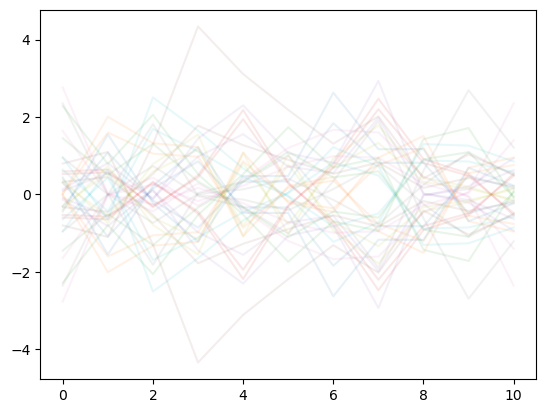

In [ ]:
key = jrn.PRNGKey(2345234235)
key, subkey_crn = jrn.split(key)

samples = simulate_cem(proposal, 10, subkey_crn)
plt.plot(samples[:,:,0].T, alpha=.1)
plt.show()

## SSM to Markov Model

To inititialize the Cross-Entropy method, we will use the Laplace approximation, see [30_laplace_approximation.ipynb]. This approximates the true posterior by the posterior of a Gaussian state space model. To initiailze the Cross-entropy procedure, we determine the Cholesky root of this Gaussian posterior and use it as an initial value. To determine the diagonal and off-diagonal components of the Cholesky root, we calcultae the joint covariance matrix $\text{Cov} \left( X_t, X_{t + 1} | Y_1, \dots, Y_n \right)$ using the Kalman smoother and the FFBS, which results in 
$$
\text{Cov} \left( X_t, X_{t + 1} | Y_1, \dots, Y_n \right) = \begin{pmatrix} 
\Xi_{t|n} & \Xi_{t|t} A_t^T \Xi_{t + 1|t}^{-1} \Xi_{t + 1|n} \\
\left(\Xi_{t|t} A_t^T \Xi_{t + 1|t}^{-1} \Xi_{t + 1|n} \right)^T & \Xi_{t + 1 | n}
\end{pmatrix}.
$$

Then the algorithm by [@Schafer2021Sparse] allows us efficiently determine the desired cholesky root.

In [ ]:
#| export
from isssm.typing import GLSSM
from isssm.kalman import kalman, smoother
def _joint_cov(Xi_smooth_t, Xi_smooth_tp1, Xi_filt_t, Xi_pred_tp1, A_t):
    """Joint covariance of conditional Markov process"""
    off_diag = Xi_filt_t @ A_t.T @ jnp.linalg.pinv(Xi_pred_tp1) @ Xi_smooth_tp1 #jnp.linalg.solve(Xi_pred_tp1, Xi_smooth_tp1)
    return jnp.block([[Xi_smooth_t, off_diag], [off_diag.T, Xi_smooth_tp1]])


def posterior_markov_proposal(y: Observations, model: GLSSM) -> CEMProposal:
    filtered = kalman(y, model)
    _, Xi_filter, _, Xi_pred = filtered
    x_smooth, Xi_smooth = smoother(filtered, model.A)

    covs = vmap(_joint_cov)(
        Xi_smooth[:-1], Xi_smooth[1:], Xi_filter[:-1], Xi_pred[1:], model.A
    )

    return proposal_from_moments(x_smooth, covs)

In [ ]:
# | export
from functools import partial
from isssm.typing import GLSSM


def log_weight_cem(
    x: Float[Array, "n+1 m"], y: Observations, model: PGSSM, proposal: CEMProposal
) -> Float:

    log_p = log_prob_joint(x, y, model)
    log_g = log_pdf(x, proposal)

    return log_p - log_g


def cross_entropy_method(
    model: PGSSM,
    y: Observations,
    N: int,
    key: PRNGKeyArray,
    n_iter: int,
) -> CEMProposal:
    key, subkey_crn = jrn.split(key)

    _, z, Omega = laplace_approximation(y, model, jnp.log(y + 1.0), n_iter)
    glssm_la = GLSSM(model.x0, model.A, model.Sigma, model.B, Omega)
    initial = posterior_markov_proposal(z, glssm_la)

    def _iteration(i, vals):
        proposal, _ = vals

        samples = simulate_cem(proposal, N, subkey_crn)

        _N, np1, m = samples.shape

        log_w = vmap(partial(log_weight_cem, y=y, model=model, proposal=proposal))(
            samples
        )
        w = normalize_weights(log_w)

        mean = jnp.sum(w[:, None, None] * samples, axis=0)
        x_consecutive = jnp.concatenate((samples[:, :-1], samples[:, 1:]), axis=-1)

        # ensure matrices (in 1D case jnp.cov reduces to (np1, m))
        consecutive_covs = vmap(partial(jnp.cov, aweights=w, rowvar=False), 1)(
            x_consecutive
        ).reshape((np1 - 1, 2 * m, 2 * m))

        return proposal_from_moments(mean, consecutive_covs), log_w

    final_proposal, log_w = fori_loop(
        0, n_iter, _iteration, (initial, jnp.empty(4 * N))
    )

    return final_proposal, log_w

In [ ]:
from isssm.importance_sampling import pgssm_importance_sampling

In [ ]:
model = nb_pgssm_runnning_example(n = 50, s_order=0, Sigma0_seasonal = jnp.eye(0), x0_seasonal=jnp.zeros(0))
key = jrn.PRNGKey(511)
key, subkey = jrn.split(key)
_, (y,) = simulate_pgssm(model, 1, subkey)
_, z_la, Omega_la = laplace_approximation(y, model, jnp.log(y + 1.0), 10)
key, subkey = jrn.split(key)
samples_la, log_w_la = pgssm_importance_sampling(y, model, z_la, Omega_la, 1000, subkey)
key, subkey = jrn.split(subkey)
proposal, log_w = cross_entropy_method(model, y, 10000, subkey, 10)
ess_pct(log_w), ess_pct(log_w_la)

(Array(92.72306807, dtype=float64), Array(75.66645645, dtype=float64))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()